In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Wed Jan 24 12:33:32 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   34C    P0    44W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [ ]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.batch_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0

hp.M = hp.n_prior_embeddings
hp.N = (hp.img_size//4)**2 * hp.batch_size

''' Find Optimum Log-Sigma'''
from util.loglikelihood import get_optimum_log_sigma

p_samples1 = (torch.rand(hp.M, hp.z_dim)*2-1).cuda()
p_samples2 = (torch.rand(hp.N, hp.z_dim)*2-1).cuda()
log_sigmas = np.array([get_optimum_log_sigma(p_samples1, p_samples2) for _ in range(100)])
optimum_log_sigma = np.median(log_sigmas)
print(optimum_log_sigma)

hp.init_log_sigma = optimum_log_sigma

In [ ]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

### Load

In [ ]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_normal_noupdate_notconst/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 7949, model_list, optimizer_list)

### Dataset

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

In [ ]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [ ]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [ ]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)
            
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

50238
lse_loss -168.10997009277344
commit_loss 1.409712553024292
recon_loss 0.015839383006095886
50239
lse_loss -173.7022247314453
commit_loss 1.410509705543518
recon_loss 0.01590031199157238
50240
lse_loss -168.66055297851562
commit_loss 1.403350830078125
recon_loss 0.016348734498023987
50241
lse_loss -175.95925903320312
commit_loss 1.4151567220687866
recon_loss 0.015054452233016491
50242
lse_loss -174.7484130859375
commit_loss 1.419693946838379
recon_loss 0.01732395961880684
50243
lse_loss -161.53857421875
commit_loss 1.4040110111236572
recon_loss 0.01863052509725094
50244
lse_loss -171.1848602294922
commit_loss 1.4340070486068726
recon_loss 0.017551477998495102
50245
lse_loss -176.266845703125
commit_loss 1.4355673789978027
recon_loss 0.014905449002981186
50246
lse_loss -172.1017608642578
commit_loss 1.4266315698623657
recon_loss 0.014816422015428543
50247
lse_loss -166.25111389160156
commit_loss 1.4412586688995361
recon_loss 0.016575369983911514
50248
lse_loss -172.98936462402344
c

50324
lse_loss -171.3216094970703
commit_loss 1.4148292541503906
recon_loss 0.016395308077335358
50325
lse_loss -174.54702758789062
commit_loss 1.4053254127502441
recon_loss 0.015740301460027695
50326
lse_loss -177.42970275878906
commit_loss 1.3983944654464722
recon_loss 0.016277333721518517
50327
lse_loss -181.6206512451172
commit_loss 1.4017627239227295
recon_loss 0.015866925939917564
50328
lse_loss -176.45782470703125
commit_loss 1.3900434970855713
recon_loss 0.015434032306075096
50329
lse_loss -172.40646362304688
commit_loss 1.4047865867614746
recon_loss 0.015116061083972454
50330
lse_loss -178.29502868652344
commit_loss 1.415330410003662
recon_loss 0.016688961535692215
50331
lse_loss -181.96914672851562
commit_loss 1.404890775680542
recon_loss 0.01719740591943264
50332
lse_loss -179.1316680908203
commit_loss 1.4051969051361084
recon_loss 0.017987405881285667
50333
lse_loss -177.00869750976562
commit_loss 1.3989906311035156
recon_loss 0.014452902600169182
50334
lse_loss -172.128067

lse_loss -175.79835510253906
commit_loss 1.423447608947754
recon_loss 0.015369060449302197
50411
lse_loss -174.1030731201172
commit_loss 1.4129053354263306
recon_loss 0.01619156077504158
50412
lse_loss -176.2160186767578
commit_loss 1.4110448360443115
recon_loss 0.016910213977098465
50413
lse_loss -180.8535919189453
commit_loss 1.407997727394104
recon_loss 0.01589452102780342
50414
lse_loss -181.39979553222656
commit_loss 1.4140573740005493
recon_loss 0.015712810680270195
50415
lse_loss -176.65846252441406
commit_loss 1.4048442840576172
recon_loss 0.017297422513365746
50416
lse_loss -178.13058471679688
commit_loss 1.3917462825775146
recon_loss 0.015371469780802727
50417
lse_loss -180.73196411132812
commit_loss 1.412165880203247
recon_loss 0.015927432104945183
50418
lse_loss -168.59898376464844
commit_loss 1.4074140787124634
recon_loss 0.016307557001709938
50419
lse_loss -183.22642517089844
commit_loss 1.3981969356536865
recon_loss 0.01491224579513073
50420
lse_loss -178.7744598388672
c

In [17]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done


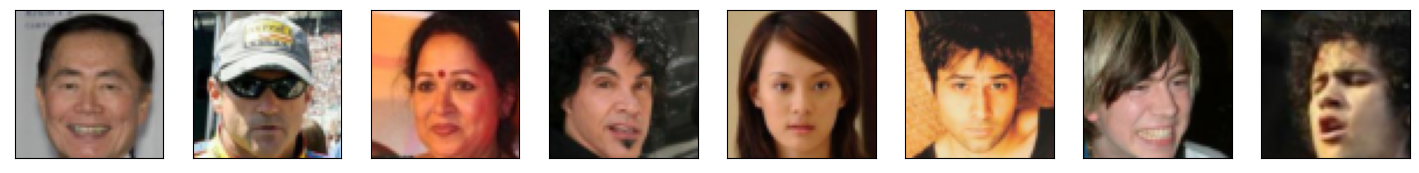

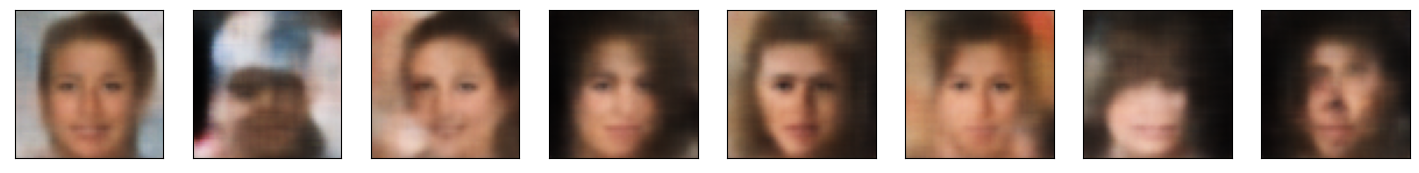

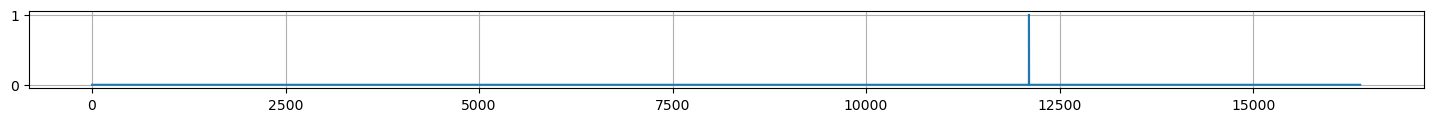

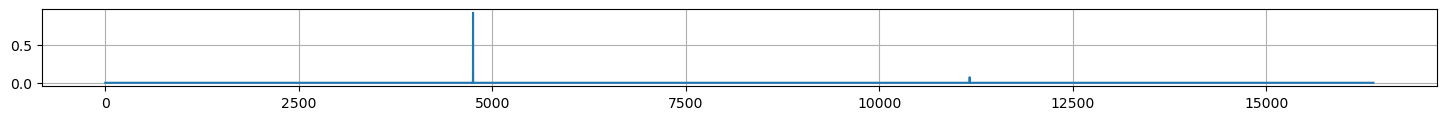

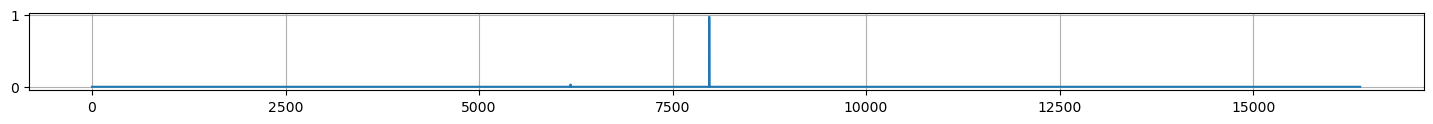

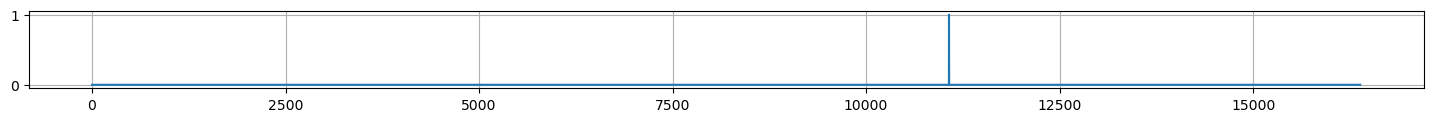

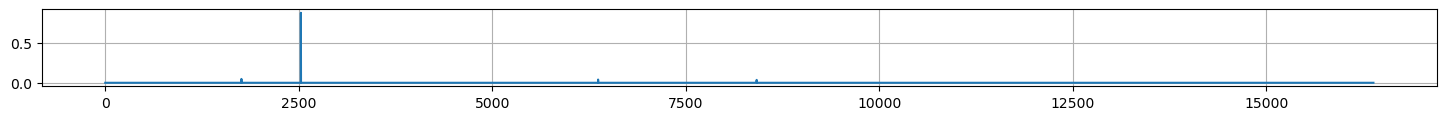

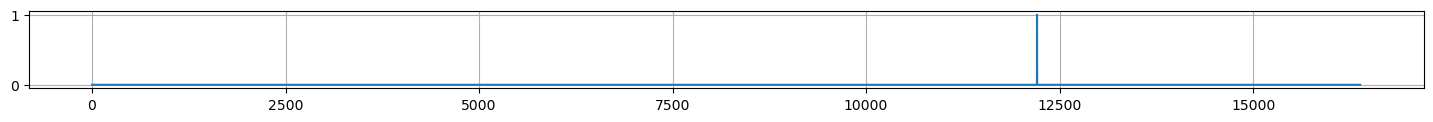

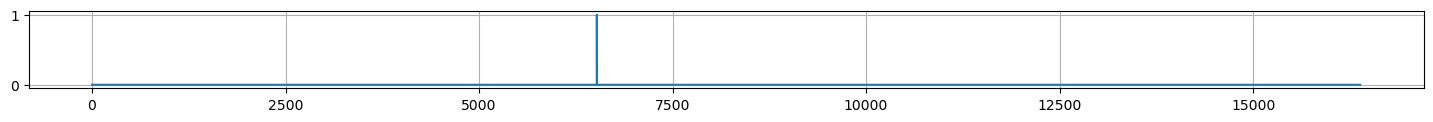

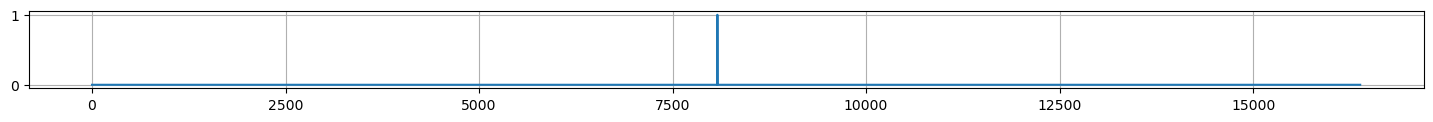

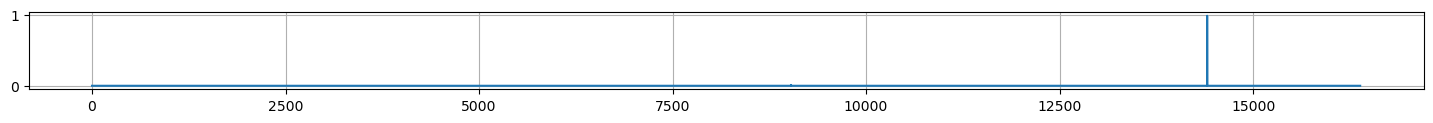

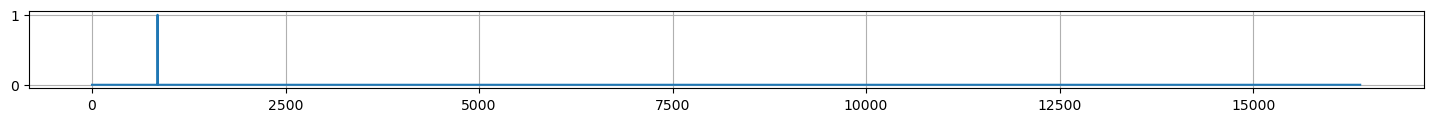

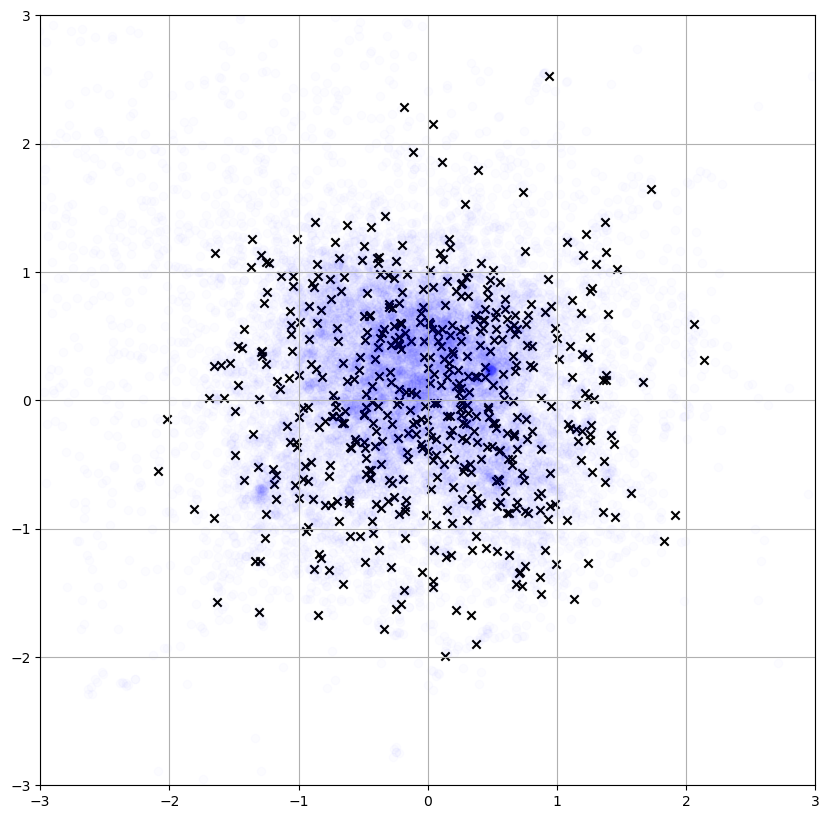

In [20]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.grid()
plt.show() 